# Setup

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

# Instantiate a brand new model

In [2]:
# config file
from config import ModelConfig, TrainConfig
cfg = ModelConfig()
tcfg = TrainConfig()
print(cfg, '\n\n', tcfg)

# import the tokenizer specified by cfg
from tools import import_from_nested_path
imported_objects = import_from_nested_path(['tokenizers', cfg.tokenizer], 'tokenizer', ['get_tokenizer'])
get_tokenizer = imported_objects.get('get_tokenizer')
tokenizer = get_tokenizer(size = cfg.vocab_len)

# model modules
from modules.model import Model
model = Model(cfg).to(cfg.device)

# print the number of parameters in the model
print(f'\n{sum(p.numel() for p in model.parameters())/1e3}K parameters\n')
print(model)

ModelConfig(dim=192, device='cpu', tokenizer='bpe', vocab_len=8192, num_layers=6, second_resid_norm=False, mlp_hidden_mult=4, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=2, num_kv_heads=1, head_dim=96, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 TrainConfig(weight_decay=0.05, batch_size=24, max_iters=6000, eval_interval=60, eval_samples=1, checkpoint_interval=None, lr_init=1e-06, lr_max=0.1, lr_min=0.001, warmup_iters=60, final_flat_iters=600, anneal_type='cos', num_restarts=3, T_mult=2)

4011.456K parameters

Model(
  (token_embedder): Embedding(8195, 192)
  (layers): ModuleList(
    (0-5): 6 x Layer(
      (pre_attn_norm): Norm()
      (attn): MQA(
        (Wq): Linear(in_features=192, out_features=192, bias=False)
        (Wk): Linear(in_features=192, out_features=96, bias=False)
        (Wv): Linear(in_features=192, out_features=96, bias=False)
        (Wo): Lin

# Training

In [3]:
import torch
from tools import get_data_loader
from train import scheduler_lambda, train

optimizer = torch.optim.AdamW(model.parameters(), lr = tcfg.lr_max, weight_decay = tcfg.weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler_lambda)

train_data_loader = get_data_loader(batch_size=tcfg.batch_size, split='train')
test_data_loader = get_data_loader(batch_size=tcfg.batch_size, split='validation')

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


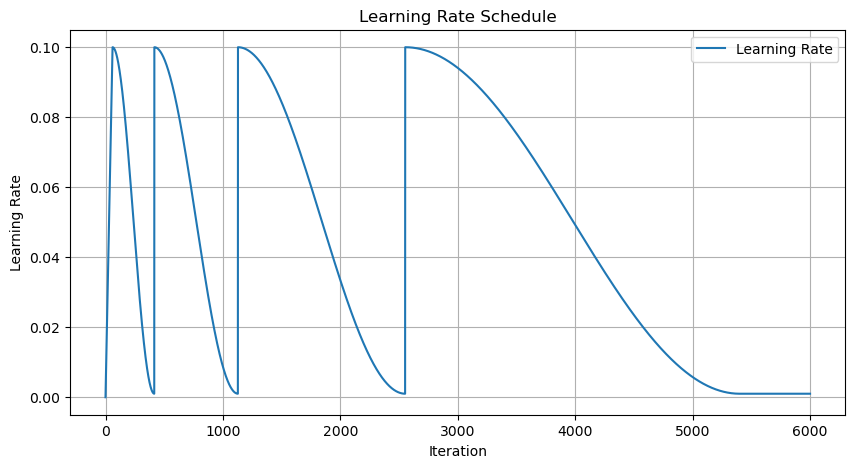

In [4]:
if True: # set to true if you'd like to see a graph of the learning rate schedule
    import matplotlib.pyplot as plt
    
    # Generate learning rate values
    lrs = [scheduler_lambda(i) for i in range(tcfg.max_iters)]
    
    # Plot the learning rates
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
model, optimizer, log_data = train(
    model, 
    tokenizer, 
    cfg, 
    optimizer,
    scheduler,
    tcfg, 
    train_data_loader,
    test_data_loader,
    #log_data: list = None, 
    #detect_anomoly = False # use if you're getting crazy errors about a the gradient being broken
)

  0%|                                                                         | 1/6000 [00:07<12:40:26,  7.61s/it]

step 0000: lr 0.000000, train loss 185.6478, val loss 185.1413, ppl inf, time elapsed: 4.47 seconds


  1%|▋                                                                       | 61/6000 [05:35<12:41:10,  7.69s/it]

step 0060: lr 0.010000, train loss 4.7006, val loss 4.5629, ppl 96, time elapsed: 331.78 seconds


  2%|█▍                                                                     | 121/6000 [12:01<12:57:25,  7.93s/it]

step 0120: lr 0.009322, train loss 3.4270, val loss 3.2548, ppl 26, time elapsed: 717.49 seconds


  3%|██▏                                                                    | 181/6000 [18:10<10:32:08,  6.52s/it]

step 0180: lr 0.007474, train loss 3.0058, val loss 2.9000, ppl 18, time elapsed: 1087.86 seconds


  4%|██▉                                                                     | 241/6000 [23:07<8:47:40,  5.50s/it]

step 0240: lr 0.004963, train loss 2.8219, val loss 2.7554, ppl 16, time elapsed: 1384.93 seconds


  5%|███▌                                                                    | 301/6000 [27:27<7:31:15,  4.75s/it]

step 0300: lr 0.002475, train loss 2.6142, val loss 2.6441, ppl 14, time elapsed: 1644.86 seconds


  6%|████▎                                                                   | 361/6000 [31:23<7:18:35,  4.67s/it]

step 0360: lr 0.000692, train loss 2.5873, val loss 2.4906, ppl 12, time elapsed: 1880.93 seconds


  7%|█████                                                                   | 421/6000 [35:14<7:42:49,  4.98s/it]

step 0420: lr 0.009999, train loss 3.2569, val loss 3.2073, ppl 25, time elapsed: 2111.49 seconds


  8%|█████▊                                                                  | 481/6000 [40:24<8:32:07,  5.57s/it]

step 0480: lr 0.009804, train loss 2.5394, val loss 2.6722, ppl 14, time elapsed: 2421.69 seconds


  9%|██████▍                                                                 | 541/6000 [44:40<7:06:54,  4.69s/it]

step 0540: lr 0.009277, train loss 2.5099, val loss 2.4901, ppl 12, time elapsed: 2677.36 seconds


 10%|███████▏                                                                | 601/6000 [48:29<6:36:51,  4.41s/it]

step 0600: lr 0.008456, train loss 2.4656, val loss 2.4047, ppl 11, time elapsed: 2907.25 seconds


 11%|███████▉                                                                | 661/6000 [52:01<5:55:06,  3.99s/it]

step 0660: lr 0.007398, train loss 2.3359, val loss 2.3365, ppl 10, time elapsed: 3119.01 seconds


 12%|████████▋                                                               | 721/6000 [55:16<5:47:48,  3.95s/it]

step 0720: lr 0.006176, train loss 2.2139, val loss 2.4011, ppl 11, time elapsed: 3314.47 seconds


 13%|█████████▎                                                              | 781/6000 [58:23<5:25:53,  3.75s/it]

step 0780: lr 0.004875, train loss 2.2493, val loss 2.1781, ppl 9, time elapsed: 3501.50 seconds


 14%|█████████▊                                                            | 841/6000 [1:01:27<5:10:34,  3.61s/it]

step 0840: lr 0.003587, train loss 2.2139, val loss 2.1501, ppl 9, time elapsed: 3684.89 seconds


 15%|██████████▌                                                           | 901/6000 [1:04:46<5:17:12,  3.73s/it]

step 0900: lr 0.002401, train loss 2.1154, val loss 2.1303, ppl 8, time elapsed: 3884.31 seconds


 16%|███████████▏                                                          | 961/6000 [1:07:46<5:08:29,  3.67s/it]

step 0960: lr 0.001399, train loss 2.1712, val loss 2.1010, ppl 8, time elapsed: 4064.13 seconds


 17%|███████████▋                                                         | 1021/6000 [1:10:44<5:04:47,  3.67s/it]

step 1020: lr 0.000651, train loss 2.0427, val loss 2.0826, ppl 8, time elapsed: 4241.60 seconds


 18%|████████████▍                                                        | 1081/6000 [1:13:39<4:49:07,  3.53s/it]

step 1080: lr 0.000211, train loss 2.1549, val loss 2.0145, ppl 7, time elapsed: 4417.30 seconds


 19%|█████████████                                                        | 1141/6000 [1:16:36<5:03:40,  3.75s/it]

step 1140: lr 0.009998, train loss 2.2515, val loss 2.1639, ppl 9, time elapsed: 4593.65 seconds


 20%|█████████████▊                                                       | 1201/6000 [1:19:53<5:25:25,  4.07s/it]

step 1200: lr 0.009938, train loss 2.1057, val loss 2.1767, ppl 9, time elapsed: 4791.10 seconds


 21%|██████████████▌                                                      | 1261/6000 [1:23:19<5:29:04,  4.17s/it]

step 1260: lr 0.009792, train loss 2.2521, val loss 2.1103, ppl 8, time elapsed: 4997.02 seconds


 22%|███████████████▏                                                     | 1321/6000 [1:26:39<5:20:39,  4.11s/it]

step 1320: lr 0.009563, train loss 2.0591, val loss 1.8419, ppl 6, time elapsed: 5196.87 seconds


 23%|███████████████▉                                                     | 1381/6000 [1:30:01<5:08:59,  4.01s/it]

step 1380: lr 0.009255, train loss 1.8636, val loss 1.8837, ppl 7, time elapsed: 5398.63 seconds


 24%|████████████████▌                                                    | 1441/6000 [1:33:18<5:03:36,  4.00s/it]

step 1440: lr 0.008873, train loss 1.8392, val loss 1.8483, ppl 6, time elapsed: 5596.37 seconds


 25%|█████████████████▎                                                   | 1501/6000 [1:36:34<4:53:53,  3.92s/it]

step 1500: lr 0.008424, train loss 1.8684, val loss 1.7761, ppl 6, time elapsed: 5792.31 seconds


 26%|█████████████████▉                                                   | 1561/6000 [1:39:50<4:57:44,  4.02s/it]

step 1560: lr 0.007917, train loss 1.8162, val loss 1.6301, ppl 5, time elapsed: 5988.45 seconds


 27%|██████████████████▋                                                  | 1621/6000 [1:43:08<4:46:18,  3.92s/it]

step 1620: lr 0.007359, train loss 1.7697, val loss 1.7263, ppl 6, time elapsed: 6186.57 seconds


 28%|███████████████████▎                                                 | 1681/6000 [1:46:27<4:48:45,  4.01s/it]

step 1680: lr 0.006761, train loss 1.7312, val loss 1.6943, ppl 5, time elapsed: 6384.82 seconds


 29%|████████████████████                                                 | 1741/6000 [1:49:47<4:45:38,  4.02s/it]

step 1740: lr 0.006133, train loss 1.6523, val loss 1.7922, ppl 6, time elapsed: 6585.10 seconds


 30%|████████████████████▋                                                | 1801/6000 [1:53:08<4:39:02,  3.99s/it]

step 1800: lr 0.005486, train loss 1.6446, val loss 1.5918, ppl 5, time elapsed: 6785.90 seconds


 31%|█████████████████████▍                                               | 1861/6000 [1:56:29<4:35:36,  4.00s/it]

step 1860: lr 0.004832, train loss 1.5042, val loss 1.5561, ppl 5, time elapsed: 6986.70 seconds


 32%|██████████████████████                                               | 1921/6000 [1:59:50<4:33:17,  4.02s/it]

step 1920: lr 0.004181, train loss 1.5300, val loss 1.6292, ppl 5, time elapsed: 7188.41 seconds


 33%|██████████████████████▊                                              | 1981/6000 [2:03:14<4:30:57,  4.05s/it]

step 1980: lr 0.003545, train loss 1.4970, val loss 1.4579, ppl 4, time elapsed: 7391.64 seconds


 34%|███████████████████████▍                                             | 2041/6000 [2:06:36<4:29:04,  4.08s/it]

step 2040: lr 0.002936, train loss 1.4892, val loss 1.5866, ppl 5, time elapsed: 7594.13 seconds


 35%|████████████████████████▏                                            | 2101/6000 [2:10:00<4:26:45,  4.10s/it]

step 2100: lr 0.002364, train loss 1.4324, val loss 1.4900, ppl 4, time elapsed: 7798.44 seconds


 36%|████████████████████████▊                                            | 2161/6000 [2:13:24<4:21:34,  4.09s/it]

step 2160: lr 0.001839, train loss 1.4651, val loss 1.4915, ppl 4, time elapsed: 8001.88 seconds


 37%|█████████████████████████▌                                           | 2221/6000 [2:16:47<4:14:17,  4.04s/it]

step 2220: lr 0.001369, train loss 1.5526, val loss 1.4086, ppl 4, time elapsed: 8204.82 seconds


 38%|██████████████████████████▏                                          | 2281/6000 [2:20:09<4:10:01,  4.03s/it]

step 2280: lr 0.000965, train loss 1.3874, val loss 1.2894, ppl 4, time elapsed: 8407.59 seconds


 39%|██████████████████████████▉                                          | 2341/6000 [2:23:32<4:06:33,  4.04s/it]

step 2340: lr 0.000632, train loss 1.4608, val loss 1.4591, ppl 4, time elapsed: 8610.15 seconds


 40%|███████████████████████████▌                                         | 2401/6000 [2:26:54<4:01:57,  4.03s/it]

step 2400: lr 0.000376, train loss 1.3263, val loss 1.4205, ppl 4, time elapsed: 8811.61 seconds


 41%|████████████████████████████▎                                        | 2461/6000 [2:30:15<3:57:56,  4.03s/it]

step 2460: lr 0.000202, train loss 1.3795, val loss 1.4421, ppl 4, time elapsed: 9012.59 seconds


 42%|████████████████████████████▉                                        | 2521/6000 [2:33:35<3:53:59,  4.04s/it]

step 2520: lr 0.000112, train loss 1.4545, val loss 1.4238, ppl 4, time elapsed: 9212.77 seconds


 43%|█████████████████████████████▋                                       | 2581/6000 [2:36:55<3:49:18,  4.02s/it]

step 2580: lr 0.009998, train loss 1.6576, val loss 1.6141, ppl 5, time elapsed: 9412.71 seconds


 44%|██████████████████████████████▎                                      | 2641/6000 [2:40:17<3:48:07,  4.07s/it]

step 2640: lr 0.009977, train loss 1.5822, val loss 1.6112, ppl 5, time elapsed: 9615.01 seconds


 45%|███████████████████████████████                                      | 2701/6000 [2:43:41<3:45:34,  4.10s/it]

step 2700: lr 0.009934, train loss 1.6322, val loss 1.4925, ppl 4, time elapsed: 9818.71 seconds


 46%|███████████████████████████████▊                                     | 2761/6000 [2:47:04<3:39:04,  4.06s/it]

step 2760: lr 0.009870, train loss 1.4327, val loss 1.4754, ppl 4, time elapsed: 10021.83 seconds


 47%|████████████████████████████████▍                                    | 2821/6000 [2:50:26<3:32:31,  4.01s/it]

step 2820: lr 0.009785, train loss 1.4880, val loss 1.4564, ppl 4, time elapsed: 10224.09 seconds


 48%|█████████████████████████████████▏                                   | 2881/6000 [2:53:46<3:24:26,  3.93s/it]

step 2880: lr 0.009680, train loss 1.5343, val loss 1.4668, ppl 4, time elapsed: 10424.56 seconds


 49%|█████████████████████████████████▊                                   | 2941/6000 [2:57:00<3:17:42,  3.88s/it]

step 2940: lr 0.009554, train loss 1.5003, val loss 1.4087, ppl 4, time elapsed: 10618.52 seconds


 50%|██████████████████████████████████▌                                  | 3001/6000 [3:00:09<3:05:38,  3.71s/it]

step 3000: lr 0.009408, train loss 1.3891, val loss 1.3314, ppl 4, time elapsed: 10807.10 seconds


 51%|███████████████████████████████████▏                                 | 3061/6000 [3:03:16<4:02:00,  4.94s/it]

step 3060: lr 0.009243, train loss 1.4521, val loss 1.4038, ppl 4, time elapsed: 10993.58 seconds


 52%|███████████████████████████████████▉                                 | 3121/6000 [3:06:29<2:55:29,  3.66s/it]

step 3120: lr 0.009060, train loss 1.3642, val loss 1.3679, ppl 4, time elapsed: 11187.30 seconds


 53%|████████████████████████████████████▌                                | 3181/6000 [3:09:25<2:45:20,  3.52s/it]

step 3180: lr 0.008859, train loss 1.3797, val loss 1.3755, ppl 4, time elapsed: 11363.49 seconds


 54%|█████████████████████████████████████▎                               | 3241/6000 [3:12:18<2:43:04,  3.55s/it]

step 3240: lr 0.008642, train loss 1.3330, val loss 1.3519, ppl 4, time elapsed: 11535.64 seconds


 55%|█████████████████████████████████████▉                               | 3301/6000 [3:15:07<2:36:25,  3.48s/it]

step 3300: lr 0.008408, train loss 1.3097, val loss 1.2765, ppl 4, time elapsed: 11705.21 seconds


 56%|██████████████████████████████████████▋                              | 3361/6000 [3:17:55<2:32:41,  3.47s/it]

step 3360: lr 0.008161, train loss 1.3962, val loss 1.2851, ppl 4, time elapsed: 11873.20 seconds


 57%|███████████████████████████████████████▎                             | 3421/6000 [3:20:45<2:35:26,  3.62s/it]

step 3420: lr 0.007899, train loss 1.3949, val loss 1.3172, ppl 4, time elapsed: 12043.24 seconds


 58%|████████████████████████████████████████                             | 3481/6000 [3:23:35<2:27:38,  3.52s/it]

step 3480: lr 0.007625, train loss 1.1958, val loss 1.2493, ppl 3, time elapsed: 12213.41 seconds


 59%|████████████████████████████████████████▋                            | 3541/6000 [3:26:22<2:20:17,  3.42s/it]

step 3540: lr 0.007340, train loss 1.3318, val loss 1.2342, ppl 3, time elapsed: 12380.21 seconds


 60%|█████████████████████████████████████████▍                           | 3601/6000 [3:29:09<2:17:56,  3.45s/it]

step 3600: lr 0.007045, train loss 1.3016, val loss 1.2445, ppl 3, time elapsed: 12547.55 seconds


 61%|██████████████████████████████████████████                           | 3661/6000 [3:31:54<2:11:23,  3.37s/it]

step 3660: lr 0.006741, train loss 1.1934, val loss 1.2952, ppl 4, time elapsed: 12712.66 seconds


 62%|██████████████████████████████████████████▊                          | 3721/6000 [3:34:42<2:11:29,  3.46s/it]

step 3720: lr 0.006429, train loss 1.2925, val loss 1.1909, ppl 3, time elapsed: 12879.89 seconds


 63%|███████████████████████████████████████████▍                         | 3781/6000 [3:37:29<2:07:39,  3.45s/it]

step 3780: lr 0.006112, train loss 1.2382, val loss 1.2527, ppl 3, time elapsed: 13046.79 seconds


 64%|████████████████████████████████████████████▏                        | 3841/6000 [3:40:25<2:04:02,  3.45s/it]

step 3840: lr 0.005790, train loss 1.1563, val loss 1.2639, ppl 4, time elapsed: 13222.82 seconds


 65%|████████████████████████████████████████████▊                        | 3901/6000 [3:43:13<2:01:24,  3.47s/it]

step 3900: lr 0.005464, train loss 1.1914, val loss 1.2450, ppl 3, time elapsed: 13391.29 seconds


 66%|█████████████████████████████████████████████▌                       | 3961/6000 [3:46:01<1:59:26,  3.51s/it]

step 3960: lr 0.005137, train loss 1.1603, val loss 1.1169, ppl 3, time elapsed: 13559.23 seconds


 67%|██████████████████████████████████████████████▏                      | 4021/6000 [3:48:50<1:56:05,  3.52s/it]

step 4020: lr 0.004810, train loss 1.1773, val loss 1.1835, ppl 3, time elapsed: 13727.46 seconds


 68%|██████████████████████████████████████████████▉                      | 4081/6000 [3:51:37<1:48:14,  3.38s/it]

step 4080: lr 0.004483, train loss 1.1570, val loss 1.2654, ppl 4, time elapsed: 13895.43 seconds


 69%|███████████████████████████████████████████████▌                     | 4141/6000 [3:54:24<1:45:39,  3.41s/it]

step 4140: lr 0.004159, train loss 1.2783, val loss 1.0933, ppl 3, time elapsed: 14062.73 seconds


 70%|████████████████████████████████████████████████▎                    | 4201/6000 [3:57:10<1:41:30,  3.39s/it]

step 4200: lr 0.003839, train loss 1.1051, val loss 1.2047, ppl 3, time elapsed: 14228.77 seconds


 71%|█████████████████████████████████████████████████                    | 4261/6000 [3:59:59<1:40:48,  3.48s/it]

step 4260: lr 0.003525, train loss 1.1966, val loss 1.1405, ppl 3, time elapsed: 14396.70 seconds


 72%|█████████████████████████████████████████████████▋                   | 4321/6000 [4:02:45<1:34:46,  3.39s/it]

step 4320: lr 0.003216, train loss 1.1714, val loss 1.0898, ppl 3, time elapsed: 14562.90 seconds


 73%|██████████████████████████████████████████████████▍                  | 4381/6000 [4:05:31<1:31:56,  3.41s/it]

step 4380: lr 0.002916, train loss 1.1407, val loss 1.0318, ppl 3, time elapsed: 14729.50 seconds


 74%|███████████████████████████████████████████████████                  | 4441/6000 [4:08:18<1:29:06,  3.43s/it]

step 4440: lr 0.002626, train loss 1.0702, val loss 1.1104, ppl 3, time elapsed: 14895.78 seconds


 75%|███████████████████████████████████████████████████▊                 | 4501/6000 [4:11:05<1:26:13,  3.45s/it]

step 4500: lr 0.002345, train loss 1.1371, val loss 1.0598, ppl 3, time elapsed: 15063.32 seconds


 76%|████████████████████████████████████████████████████▍                | 4561/6000 [4:13:52<1:23:14,  3.47s/it]

step 4560: lr 0.002077, train loss 1.1252, val loss 1.0761, ppl 3, time elapsed: 15230.37 seconds


 77%|█████████████████████████████████████████████████████▏               | 4621/6000 [4:16:39<1:19:10,  3.44s/it]

step 4620: lr 0.001822, train loss 1.0935, val loss 1.1005, ppl 3, time elapsed: 15397.09 seconds


 78%|█████████████████████████████████████████████████████▊               | 4681/6000 [4:19:26<1:15:19,  3.43s/it]

step 4680: lr 0.001581, train loss 1.1322, val loss 1.0655, ppl 3, time elapsed: 15563.99 seconds


 79%|██████████████████████████████████████████████████████▌              | 4741/6000 [4:22:15<1:12:43,  3.47s/it]

step 4740: lr 0.001355, train loss 1.1359, val loss 1.1015, ppl 3, time elapsed: 15733.09 seconds


 80%|███████████████████████████████████████████████████████▏             | 4801/6000 [4:25:02<1:07:22,  3.37s/it]

step 4800: lr 0.001145, train loss 1.0760, val loss 1.0297, ppl 3, time elapsed: 15899.95 seconds


 81%|███████████████████████████████████████████████████████▉             | 4861/6000 [4:27:48<1:05:08,  3.43s/it]

step 4860: lr 0.000953, train loss 1.0953, val loss 0.9884, ppl 3, time elapsed: 16066.35 seconds


 82%|████████████████████████████████████████████████████████▌            | 4921/6000 [4:30:35<1:01:57,  3.45s/it]

step 4920: lr 0.000778, train loss 1.1113, val loss 1.0281, ppl 3, time elapsed: 16233.28 seconds


 83%|██████████████████████████████████████████████████████████▉            | 4981/6000 [4:33:24<58:24,  3.44s/it]

step 4980: lr 0.000622, train loss 1.0965, val loss 1.0447, ppl 3, time elapsed: 16402.18 seconds


 84%|███████████████████████████████████████████████████████████▋           | 5041/6000 [4:36:10<53:59,  3.38s/it]

step 5040: lr 0.000485, train loss 1.0644, val loss 1.0109, ppl 3, time elapsed: 16568.27 seconds


 85%|████████████████████████████████████████████████████████████▎          | 5101/6000 [4:38:56<50:38,  3.38s/it]

step 5100: lr 0.000369, train loss 1.0945, val loss 1.0375, ppl 3, time elapsed: 16734.04 seconds


 86%|█████████████████████████████████████████████████████████████          | 5161/6000 [4:41:42<47:43,  3.41s/it]

step 5160: lr 0.000272, train loss 0.9862, val loss 1.0039, ppl 3, time elapsed: 16900.55 seconds


 87%|█████████████████████████████████████████████████████████████▊         | 5221/6000 [4:44:29<44:33,  3.43s/it]

step 5220: lr 0.000197, train loss 1.1090, val loss 1.0617, ppl 3, time elapsed: 17067.45 seconds


 88%|██████████████████████████████████████████████████████████████▍        | 5281/6000 [4:47:16<44:10,  3.69s/it]

step 5280: lr 0.000143, train loss 1.0905, val loss 0.9508, ppl 3, time elapsed: 17234.60 seconds


 89%|███████████████████████████████████████████████████████████████▏       | 5341/6000 [4:50:02<36:51,  3.36s/it]

step 5340: lr 0.000111, train loss 1.0932, val loss 1.0741, ppl 3, time elapsed: 17400.33 seconds


 90%|███████████████████████████████████████████████████████████████▉       | 5401/6000 [4:52:48<34:10,  3.42s/it]

step 5400: lr 0.000100, train loss 1.0651, val loss 1.1022, ppl 3, time elapsed: 17566.34 seconds


 91%|████████████████████████████████████████████████████████████████▌      | 5461/6000 [4:55:34<30:22,  3.38s/it]

step 5460: lr 0.000100, train loss 0.9584, val loss 1.0306, ppl 3, time elapsed: 17732.71 seconds


 92%|█████████████████████████████████████████████████████████████████▎     | 5521/6000 [4:58:20<26:49,  3.36s/it]

step 5520: lr 0.000100, train loss 0.9235, val loss 0.9999, ppl 3, time elapsed: 17897.81 seconds


 93%|██████████████████████████████████████████████████████████████████     | 5581/6000 [5:01:06<24:08,  3.46s/it]

step 5580: lr 0.000100, train loss 1.0375, val loss 1.0879, ppl 3, time elapsed: 18064.01 seconds


 94%|██████████████████████████████████████████████████████████████████▊    | 5641/6000 [5:04:04<29:59,  5.01s/it]

step 5640: lr 0.000100, train loss 1.1040, val loss 1.0370, ppl 3, time elapsed: 18239.82 seconds


 95%|███████████████████████████████████████████████████████████████████▍   | 5701/6000 [5:07:04<17:35,  3.53s/it]

step 5700: lr 0.000100, train loss 1.0883, val loss 0.9615, ppl 3, time elapsed: 18421.67 seconds


 96%|████████████████████████████████████████████████████████████████████▏  | 5761/6000 [5:09:54<13:45,  3.46s/it]

step 5760: lr 0.000100, train loss 1.0467, val loss 1.0407, ppl 3, time elapsed: 18591.72 seconds


 97%|████████████████████████████████████████████████████████████████████▉  | 5821/6000 [5:12:43<10:21,  3.47s/it]

step 5820: lr 0.000100, train loss 0.9506, val loss 1.0494, ppl 3, time elapsed: 18760.81 seconds


 98%|█████████████████████████████████████████████████████████████████████▌ | 5881/6000 [5:15:33<07:02,  3.55s/it]

step 5880: lr 0.000100, train loss 1.1349, val loss 0.9856, ppl 3, time elapsed: 18930.77 seconds


 99%|██████████████████████████████████████████████████████████████████████▎| 5941/6000 [5:18:22<03:26,  3.49s/it]

step 5940: lr 0.000100, train loss 0.9628, val loss 0.9934, ppl 3, time elapsed: 19100.35 seconds


100%|███████████████████████████████████████████████████████████████████████| 6000/6000 [5:21:09<00:00,  3.21s/it]

step 5999: lr 0.000100, train loss 1.0040, val loss 1.0425, ppl 3, time elapsed: 19267.01 seconds


# inference test before you decide to save it

In [6]:
from inference import generate
prompt = "Once upon a time"
model.eval()
output = generate(
    prompt, 
    model, 
    tokenizer,
    #max_gen_len = 512,
    temperature = 0.9,
    #memory_saver_div = 8,
    #top_p = 0.9,
    #top_k = 32,
)
model.train()
print(output)

Once upon a time, there was a little girl named Amy. Amy had a ball that she loved to play. She had a toy that her favorite toy loved to play with. One day, she saw a big box. She wanted to find a toy.
Amy asked her mom, "Mom, look at this toy, Mr. Bear is simple." Her mom looked at the toy and said, "You need to fight in the box every day."
Amy put the toy in her toy box and made her strong care of the box. The toy went up and down, and the toy box got driver up. Amy was very happy. She said, "Thank you, Amy! I love you!" She smiled and felt proud that she made a big mess. Amy learned that being gentle is good and kind to others.


# Saving your final model
if `tcfg.checkpoint_interval != None` then checkpoints have already been saved

you DO still need to do this even if you had been saving checkpoints; the final state has not yet been saved

In [7]:
from tools import save_model
save_model(model, cfg, tcfg, log_data)